In [1]:
# Ячейка обязательная, если запускать в коллабе, чтобы файле сохранились на диске
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/all_gazeta

/content/drive/MyDrive/all_gazeta


In [3]:
!pip install bigartm10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.7 MB/s eta 0:00:00


In [4]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

import pandas as pd
import seaborn as sns

import numpy as np

In [5]:
!sudo apt-get --reinstall install ttf-mscorefonts-installer

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cabextract distro-info libfontenc1 libmspack0 python3-chardet
  python3-debconf python3-debian python3-distro-info python3-distupgrade
  python3-update-manager python3-yaml ubuntu-advantage-tools ubuntu-pro-client
  ubuntu-pro-client-l10n ubuntu-release-upgrader-core update-manager-core
  update-notifier-common xfonts-encodings xfonts-utils zstd
Suggested packages:
  shunit2
The following NEW packages will be installed:
  cabextract distro-info libfontenc1 libmspack0 python3-chardet
  python3-debconf python3-debian python3-distro-info python3-distupgrade
  python3-update-manager python3-yaml ttf-mscorefonts-installer
  ubuntu-advantage-tools ubuntu-pro-client ubuntu-pro-client-l10n
  ubuntu-release-upgrader-core update-manager-core update-notifier-common
  xfonts-encodings xfonts-utils zstd
0 upgraded, 21 newly installed, 0 to remove an

In [6]:
import matplotlib.font_manager as fm
for fontpath in fm.findSystemFonts():
    fm.fontManager.addfont(fontpath)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


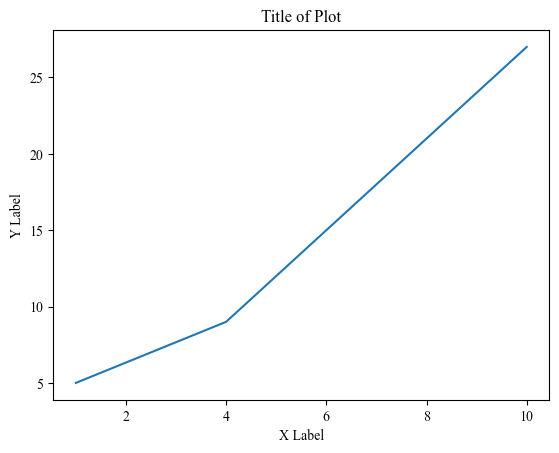

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['font.family']='Times New Roman'
#define x and y
x = [1, 4, 10]
y = [5, 9, 27]

#create line plot
plt.plot (x, y)

#add title and axis labels
plt.title('Title of Plot')
plt.xlabel('X Label')
plt.ylabel('Y Label')

#display plot
plt.show()

### 1. BatchVectorizer

Before starting modeling we need to convert you data in the library format. At first you need to read about supporting formats for source data in Input Data Formats and Datasets. It’s your task to prepare your data in one of these formats. As you had transformed your data into one of source formats, you can convert them in the BigARTM internal format (batches of documents) using BatchVectorizer class object.

The built-in library parser converted your data into batches and covered them with the BatchVectorizer class object, that is a general input data type for all methods of Python API. The batches were places in the directory, you specified in the target_folder parameter.

In [22]:
# Подключаем ту папку lenta_ts, к файлам которой мы предварительно добавили метки времени
batch_vectorizer = None
if len(glob.glob(os.path.join('gazeta_batches_ts', '*.batch'))) < 1:
  batch_vectorizer = artm.BatchVectorizer(data_path='gazeta_ts', data_format='bow_uci',
                                                collection_name='gazeta_ts', target_folder='gazeta_batches_ts')
else:
  batch_vectorizer = artm.BatchVectorizer(data_path='gazeta_batches_ts', data_format='batches')

### 2. Dictionary

The next step is to create Dictionary. This is a data structure containing the information about all unique tokens in the collection. The dictionary is generating outside the model, and this operation can be done in different ways (load, create, gather). The most basic case is to gather dictionary using batches directory. You need to do this operation only once when starting working with new collection.

Dictionary is the object of BigARTM, containing the information about the collection (vocabulary, different counters and values, linked to tokens). Provided dictionary will be used for \Phi matrix initialization. It means:


In [23]:
if not os.path.isfile('gazeta_batches_ts/my_dictionary.dict'):
  dictionary = artm.Dictionary()
  dictionary.gather(data_path='gazeta_batches_ts')
  dictionary.save(dictionary_path='gazeta_batches_ts/my_dictionary')
  dictionary.load(dictionary_path='gazeta_batches_ts/my_dictionary.dict')
else:
  dictionary = artm.Dictionary()
  dictionary.load(dictionary_path='gazeta_batches_ts/my_dictionary.dict')

### 3. Parameters

In [53]:
# Нужно перебирать параметры и проверять оценки метрик
parameters = {
    'num_topics': 200,
    'num_back_topics': 10,
    'num_collection_passes': 20,
    'num_document_passes': 1,
    'SparsePhiRegularizer': -0.1,
    'SmoothPhiRegularizer': 0.1,
    'SparseThetaRegularizer': -0.5,
    'SmoothThetaRegularizer': 0.5,
    'DecorrelatorPhiRegularizer': 1.5e+5,
    'TopicSelectionThetaRegularizer': 0.0,
    'LabelSparsePsiRegularizer': -0.05,
    'LabelSmoothPsiRegularizer': 0.0,
    'TimestampsClassWeight': 5
}

In [54]:
num_topics = parameters['num_topics']
num_back_topics = parameters['num_back_topics']
num_collection_passes = parameters['num_collection_passes']
num_document_passes = parameters['num_document_passes']
timestamps_class_weight = parameters['TimestampsClassWeight']

topic_names = ['@topic_'+str(i) for i in range(num_topics)]

subj_topics = topic_names[:-num_back_topics]
back_topics = topic_names[-num_back_topics:]

In [55]:
model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True)

model_artm.initialize(dictionary=dictionary)

tokens_class = "@default_class"
timestamps_class = "@timestamps_class"
model_artm.class_ids = {tokens_class: 1.0, timestamps_class: timestamps_class_weight}

### 4. Regularizers
- **Smooth/Sparse Phi:** sparse subject topics to increase their quality and smooth background topics to gather there all background tokens, create two regularizers, specify topic_names parameters with corresponding list in both ones and set tau in sparsing regularizer to some negative value, and in smoothing to some positive one;
- **Smooth/Sparse Theta:** divide all topics into two groups (subject and background), sparse subject topics to increase their quality and smooth  background topics to gather there all background tokens: create two;
- **Decorrelator Phi:** deal only with the tokens of given modality: set class_ids parameter the list with names of modalities to use in this regularizer.

In [56]:
# Smooth/Sparse Phi
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer',
                                                           tau=parameters['SparsePhiRegularizer'],
                                                           topic_names=subj_topics))

model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhiRegularizer',
                                                           tau=parameters['SmoothPhiRegularizer'],
                                                           topic_names=back_topics))
# Decorrelator Phi
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiRegularizer',
                                                           tau=parameters['DecorrelatorPhiRegularizer'],
                                                           topic_names=subj_topics,
                                                           class_ids=[tokens_class]))
# TopicSelectionThetaRegularizer
model_artm.regularizers.add(artm.TopicSelectionThetaRegularizer(name='TopicSelectionThetaRegularizer',
                                                               tau=parameters['TopicSelectionThetaRegularizer'],
                                                               topic_names=subj_topics))

# Smooth/Sparse Theta
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseThetaRegularizer',
                                                             tau=parameters['SparseThetaRegularizer'],
                                                             topic_names=subj_topics))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothThetaRegularizer',
                                                             tau=parameters['SmoothThetaRegularizer'],
                                                             topic_names=back_topics))

# LabelSparsePsiRegularizer
model_artm.regularizers.add(artm.LabelRegularizationPhiRegularizer(name='LabelSparsePsiRegularizer',
                                                                  tau=parameters['LabelSparsePsiRegularizer'],
                                                                  topic_names=subj_topics,
                                                                  class_ids=[timestamps_class]))
model_artm.regularizers.add(artm.LabelRegularizationPhiRegularizer(name='LabelSmoothPsiRegularizer',
                                                                  tau=parameters['LabelSmoothPsiRegularizer'],
                                                                  topic_names=back_topics,
                                                                  class_ids=[timestamps_class]))



### 5. Add scores

In [57]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                               dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=15))

In [58]:
model_artm.num_document_passes = num_document_passes

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

In [59]:
def print_measures(model):
    print('Sparsity Phi: {0:.3f} (ARTM)'.format(
        model.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model.score_tracker['PerplexityScore'].last_value))


def print_scores(scores, save=None):
    print_measures(model_artm)
    plt.figure()
    phi, theta = None, None
    phi, = plt.plot(scores['SparsityPhiScore'].value, 'r--', linewidth=2)
    theta, = plt.plot(scores['SparsityThetaScore'].value, 'b--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Sparsity')
    plt.legend([phi, theta], ['Phi sparsity', 'Theta sparsity'])
    plt.grid(True)
    if save:
        plt.savefig(save+"_sparsity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()

    plt.figure()
    contrast, purity = None, None
    contrast, = plt.plot(scores['TopicKernelScore'].average_contrast, 'r', linewidth=2)
    purity, = plt.plot(scores['TopicKernelScore'].average_purity, 'b', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Contrast/Purity')
    plt.grid(True)
    plt.legend([contrast, purity], ['Average contrast', 'Average purity'])
    if save:
        plt.savefig(save+"_contrast_purity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()

    plt.figure()
    perp = None
    perp, = plt.plot(scores['PerplexityScore'].value, 'b--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Perplexity')
    plt.xlim(1)
    plt.legend([perp], ['Model perplexity'])
    plt.grid(True)
    if save:
        plt.savefig(save+"_perplexity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sparsity Phi: 0.895 (ARTM)
Sparsity Theta: 0.028 (ARTM)
Kernel contrast: 0.544 (ARTM)
Kernel purity: 0.017 (ARTM)
Perplexity: 5547.089 (ARTM)


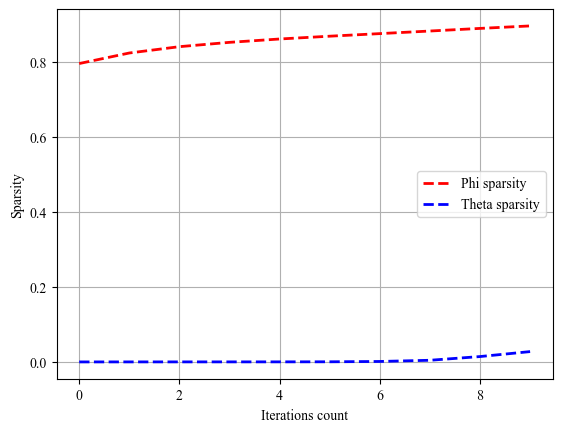

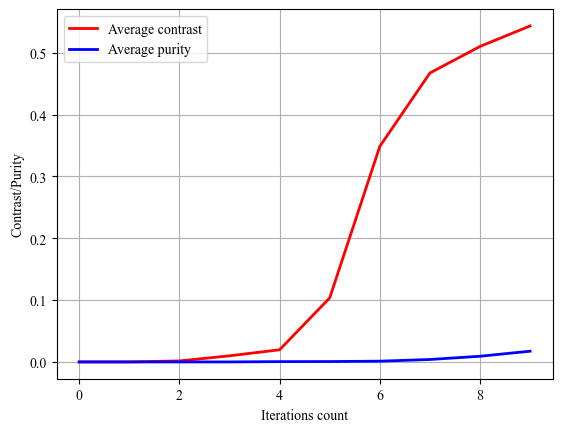

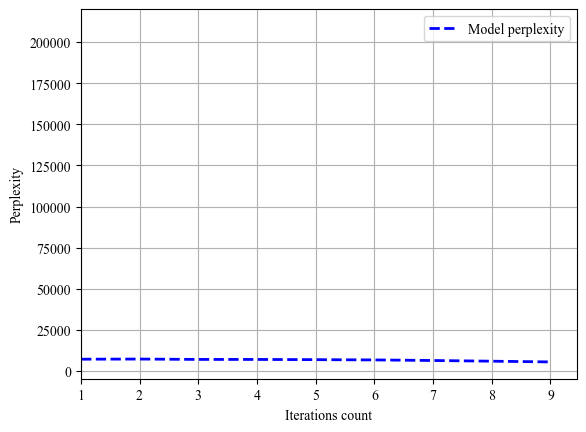

In [60]:
print_scores(model_artm.score_tracker, save=None)

In [61]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sparsity Phi: 0.913 (ARTM)
Sparsity Theta: 0.075 (ARTM)
Kernel contrast: 0.616 (ARTM)
Kernel purity: 0.084 (ARTM)
Perplexity: 4259.523 (ARTM)


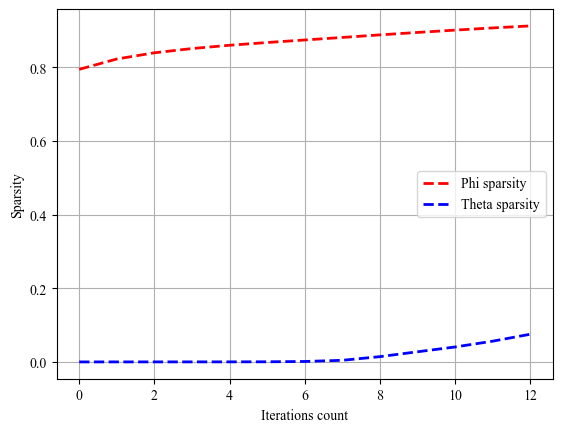

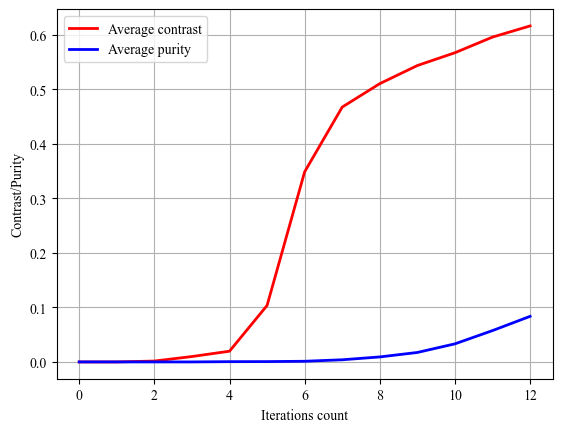

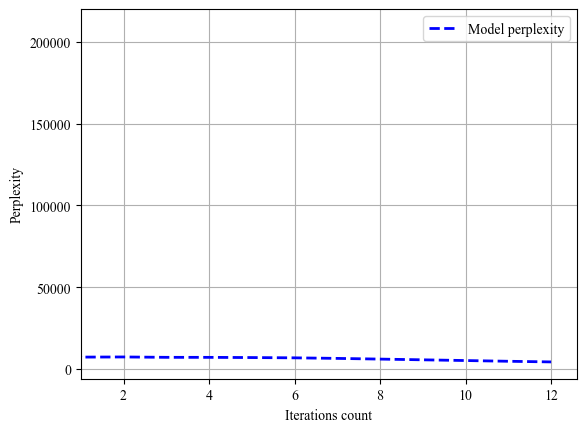

In [62]:
print_scores(model_artm.score_tracker, save=None)

In [63]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sparsity Phi: 0.921 (ARTM)
Sparsity Theta: 0.111 (ARTM)
Kernel contrast: 0.651 (ARTM)
Kernel purity: 0.140 (ARTM)
Perplexity: 3693.096 (ARTM)


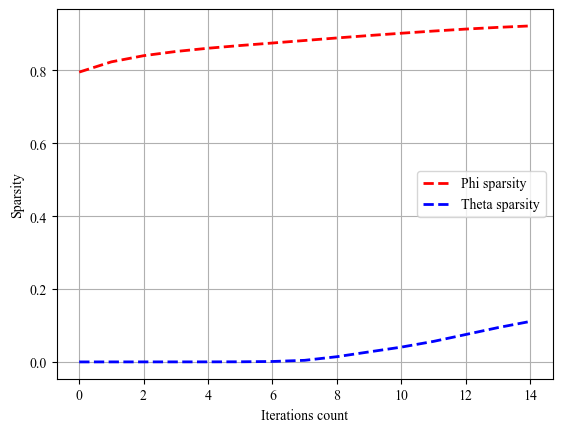

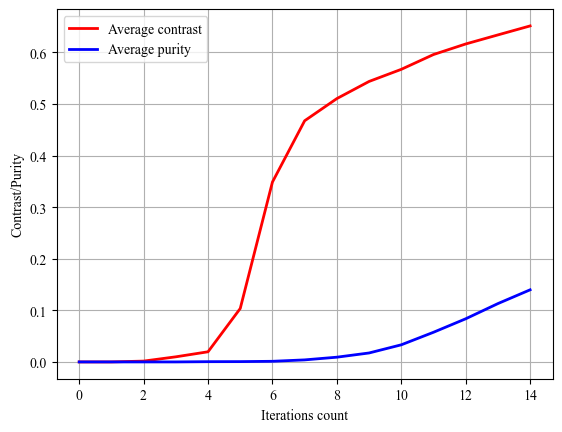

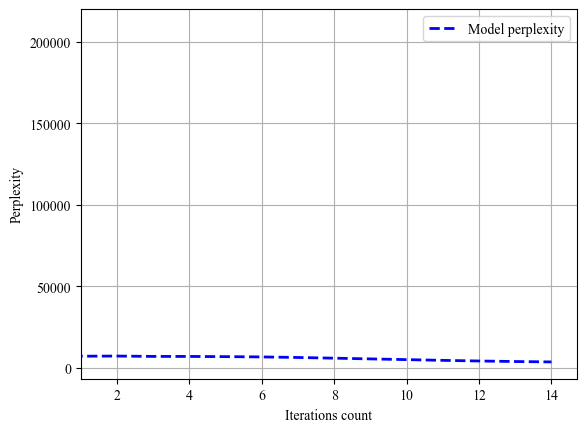

In [64]:
print_scores(model_artm.score_tracker, save=None)

In [65]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=2)

Sparsity Phi: 0.916 (ARTM)
Sparsity Theta: 0.141 (ARTM)
Kernel contrast: 0.681 (ARTM)
Kernel purity: 0.277 (ARTM)
Perplexity: nan (ARTM)


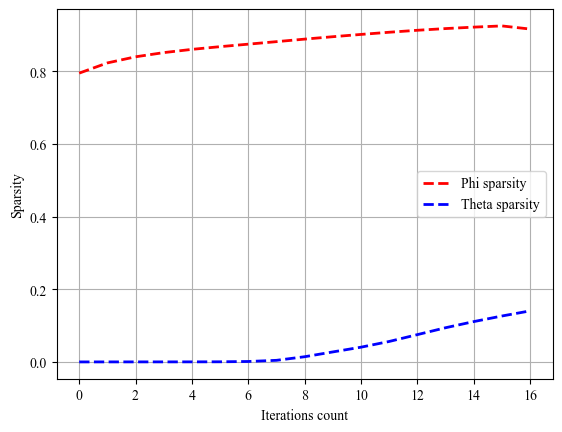

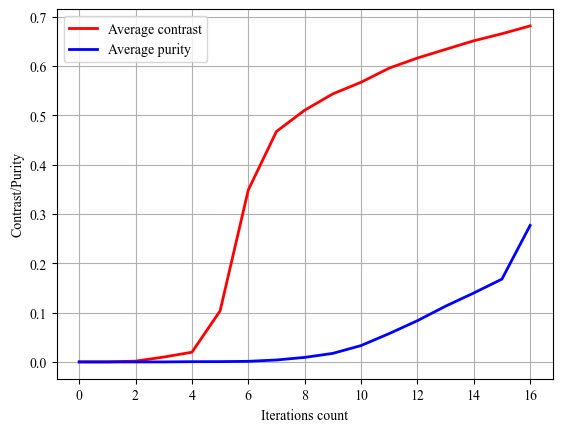

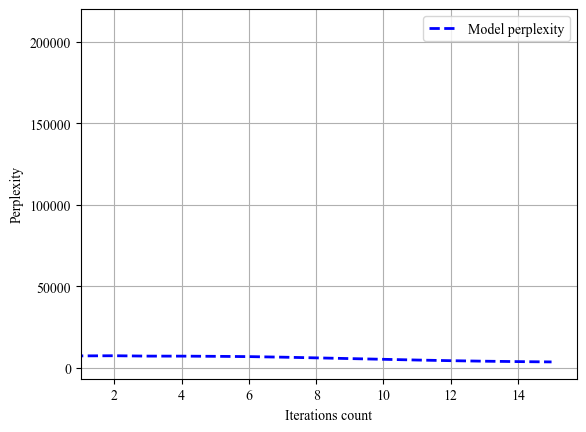

In [67]:
print_scores(model_artm.score_tracker, save='Gazeta-ARTM')

In [68]:
def plot_matrix(matrix, figsize=(20,15), xlabel='', ylabel='', title='', save=None):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.binary)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    if save:
        plt.savefig(save, format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)
    print(np.any(np.isnan(matrix)))

In [70]:
theta = model_artm.get_theta().values
phi = model_artm.get_phi().values

<>:2: DeprecationWarning: invalid escape sequence '\T'


False


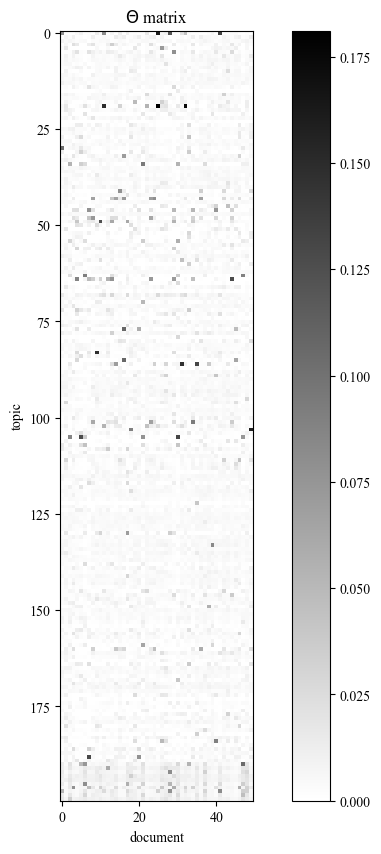

In [71]:
plot_matrix(theta[:,:50], figsize=(10,10), xlabel='document', ylabel='topic',
            title='$\Theta$ matrix', save="Gazeta-Temporal_Theta.eps")

<>:2: DeprecationWarning: invalid escape sequence '\P'


False


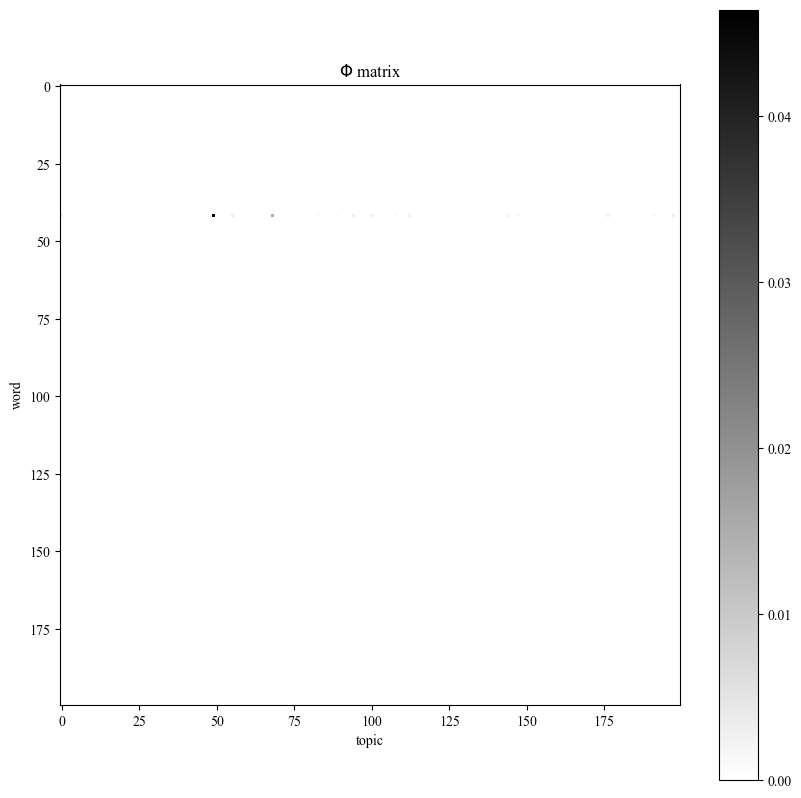

In [72]:
plot_matrix(phi[:200,:], figsize=(10,10), xlabel='topic', ylabel='word',
            title='$\Phi$ matrix', save='Gazeta-Temporal_Phi.eps')

In [73]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


@topic_0: 
['ученый', 'алкоголь', 'университет', 'мозг', 'организм', 'рак', 'пациент', 'симптом', 'употребление', 'доктор', 'диагноз', 'напиток', 'больной', 'днк', 'ткань']
@topic_1: 
['путин', 'секретарь', 'экс', 'сенатор', 'рф', 'кремль', 'вица', 'спикер', 'советник', 'республика', 'президентский', 'обсуждать', 'пранкер', 'вводить', 'беседа']
@topic_2: 
['жириновский', 'христианский', 'хдс', 'личный', 'беседа', 'некий', 'комментарий', 'отреагировать', 'следовать', 'обращение', 'ноябрь', 'дата', 'перебивать', 'джиоева', 'сентябрь']
@topic_3: 
['нато', 'вашингтон', 'су', 'оборона', 'оон', 'истребитель', 'резолюция', 'самолет', 'североатлантический', 'румыния', 'дипломат', 'ведомство', 'оборонный', 'миг', 'союзник']
@topic_4: 
['топливо', 'бензин', 'валюта', 'акциз', 'топливный', 'пошлина', 'подорожать', 'азс', 'сахар', 'ндс', 'нефтепродукт', 'минфин', 'розничный', 'масло', 'торги']
@topic_5: 
['судно', 'рф', 'вертолет', 'берег', 'ведомство', 'моряк', 'служба', 'ми', 'катер', 'спасатель

### 6. Eventness

In [74]:
phi_m = model_artm.get_phi(class_ids=[timestamps_class]).values

In [75]:
def get_pyt(phi, t):
    return np.nan_to_num(phi[:, t])


def delta_roc(pyt):
    points = []
    for delta in range(1, pyt.size):
        max_dens = 0
        for pos in range(pyt.size-delta):
            density = np.sum(pyt[pos:pos+delta])
            if density > max_dens:
                max_dens = density
        points.append((delta, 1.0-max_dens))
    return np.array(points)

def auc_delta_roc(delta_roc):
    s = 0
    return np.sum(list(map(lambda x: x[1], delta_roc)))

In [76]:
aucs = []
for t in range(parameters['num_topics']):
    aucs.append((auc_delta_roc(delta_roc(get_pyt(phi_m, t)))/73.0, t))

In [77]:
aucs_values = []
for auc in aucs:
  aucs_values.append(auc[0])

In [78]:
top_tokens = []
for topic_name in model_artm.topic_names:
    #print(topic_name + ': ')
    top_tokens.append(', '.join(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]))

In [79]:
tokens_aucs = dict(zip(top_tokens, aucs_values))

In [80]:
# Для событийных тем Delta-AUC меньше
sorted_tokens_aucs = sorted(tokens_aucs.items(), key=lambda kv: kv[1], reverse=False)
for pair in sorted_tokens_aucs[:10]:
  print('Delta-AUC ' + str(pair[1]) + ': ')
  print(pair[0])

Delta-AUC 0.1985885439670249: 
белорусский, лукашенко, минск, протест, литва, республика, белорус, интеграция, союзный, беларусь, протестовать, тихановский, кгб, польша, литовский
Delta-AUC 0.20000683240694542: 
проигрывать, очки, химки, очко, тренер, евролига, цска, баскетболист, баскетбол, баскетбольный, заключительный, финал, отрыв, швед, чемпион
Delta-AUC 0.24770459451087534: 
аппарат, спутник, искусственный, наблюдение, ранее, дыра, безопасный, лунный, контейнер, мусор, исследовательский, ведомство, ученый, зафиксировать, утечка
Delta-AUC 0.2518455655607459: 
рэпер, сердечный, рэп, комментарий, табаков, григорьев, извинение, цой, госпитализация, татьяна, поступок, слушатель, извиняться, могила, умирать
Delta-AUC 0.258413772264572: 
артистка, исполнительница, композитор, рэпер, пугачева, поделиться, киркоров, малахов, алла, клип, творческий, спеть, билан, дима, филипп
Delta-AUC 0.27292101962925636: 
телеканал, эстонский, республика, губернатор, ранее, экс, вещание, обращение, сентя

In [81]:
topics = sorted(aucs)

In [82]:
eventness_topics = list(map(lambda x: '@topic_' + str(x[1]), topics))

In [83]:
eventness_topicnums = list(map(lambda x: x[1], topics))

<>:2: DeprecationWarning: invalid escape sequence '\X'


True


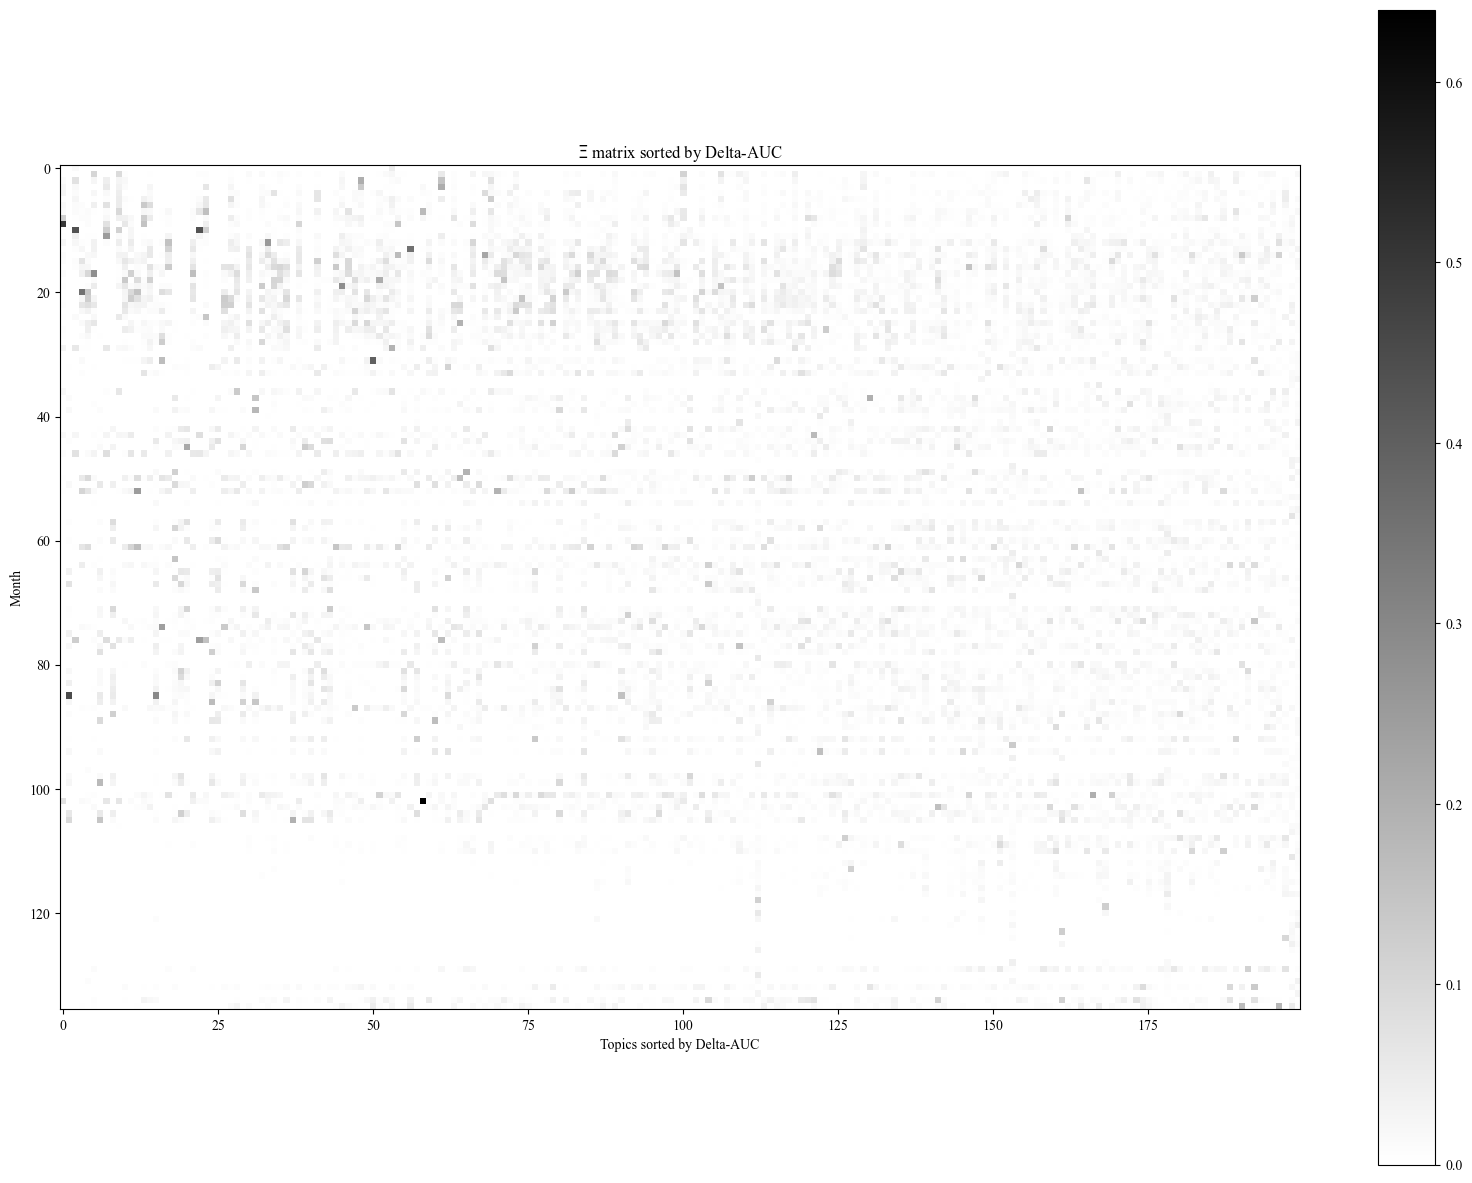

In [84]:
plot_matrix(phi_m[:, eventness_topicnums],
            xlabel='Topics sorted by Delta-AUC', ylabel='Month', title='$\Xi$ matrix sorted by Delta-AUC', save="Gazeta-Temporal_sorted_by_auc_Xi.eps")

In [85]:
eventness_topicnums[:10]

[103, 87, 68, 107, 105, 137, 65, 19, 122, 0]

In [86]:
def print_topics(topic_names=None, weights=False):
    if topic_names is None:
        topic_names = model_artm.topic_names
    for topic_name in topic_names:
        print(topic_name + ': ')
        tokens = model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]
        if weights:
            weights = model_artm.score_tracker['TopTokensScore'].last_weights[topic_name]
            for token, weight in zip(tokens, weights):
                print("({0}, {1:.3f}), ".format(token, weight))
            print()
        else:
            print(', '.join(tokens))
        print()

In [87]:
print_topics(eventness_topics)

@topic_103: 
белорусский, лукашенко, минск, протест, литва, республика, белорус, интеграция, союзный, беларусь, протестовать, тихановский, кгб, польша, литовский

@topic_87: 
проигрывать, очки, химки, очко, тренер, евролига, цска, баскетболист, баскетбол, баскетбольный, заключительный, финал, отрыв, швед, чемпион

@topic_68: 
аппарат, спутник, искусственный, наблюдение, ранее, дыра, безопасный, лунный, контейнер, мусор, исследовательский, ведомство, ученый, зафиксировать, утечка

@topic_107: 
рэпер, сердечный, рэп, комментарий, табаков, григорьев, извинение, цой, госпитализация, татьяна, поступок, слушатель, извиняться, могила, умирать

@topic_105: 
артистка, исполнительница, композитор, рэпер, пугачева, поделиться, киркоров, малахов, алла, клип, творческий, спеть, билан, дима, филипп

@topic_137: 
телеканал, эстонский, республика, губернатор, ранее, экс, вещание, обращение, сентябрь, мэр, руководитель, паспорт, биометрический, эстония, кальюлайд

@topic_65: 
лига, сити, испания, челси

In [88]:
eventness_topicnums[-10:]

[46, 53, 117, 33, 184, 20, 157, 86, 63, 130]

In [89]:
def plot_pyt(phi, t, logscale=False, save=None, title=None):
    if not title:
        title = 'Month distribution given @topic{0}'.format(t)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    pyt = get_pyt(phi, t)
    ax.plot(pyt)
    if logscale:
        ax.set_yscale('log')
    plt.title(title)
    plt.xlabel('y')
    plt.ylabel('p(y $|$ @topic{0})'.format(t))
    plt.ylim(0, 1.0)
    plt.xlim(0, 147)
    plt.grid(True)
    if save:
        plt.savefig(save, format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

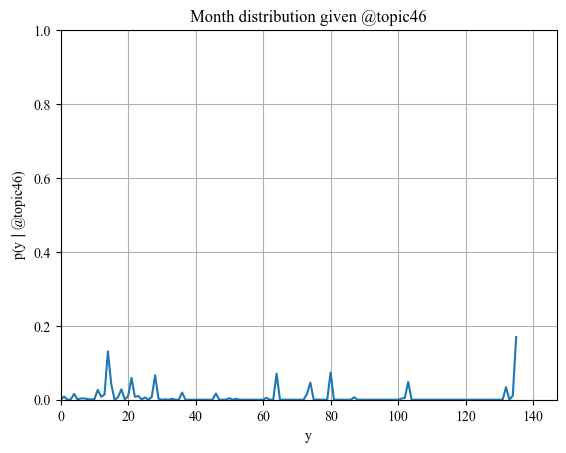

In [90]:
plot_pyt(phi_m, 46, title=None, save=None)

In [91]:
def get_phi_timestamps(model):
    phi_m = model.get_phi(class_ids=[timestamps_class])
    phi_m.index = phi_m.index.map(lambda x: int(x[1]))
    phi_m = phi_m.sort_index()
    return phi_m.values

phi_m = get_phi_timestamps(model_artm)

In [92]:
def get_corr_matrix(phi):
    df = pd.DataFrame(phi)
    return df.corr()

phi = model_artm.get_phi(class_ids=[tokens_class]).values
corr_matrix = get_corr_matrix(phi).values

In [96]:
def plot_corr_matrix(matrix, save=None):
    #sns.set(style="white")
    sns.set (font_scale = 2)
    f, ax = plt.subplots(figsize=(50, 50))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(matrix, cmap='Greens', vmin=0.0,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title('Topic-topic correlation matrix')
    if save:
        plt.savefig(save, format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

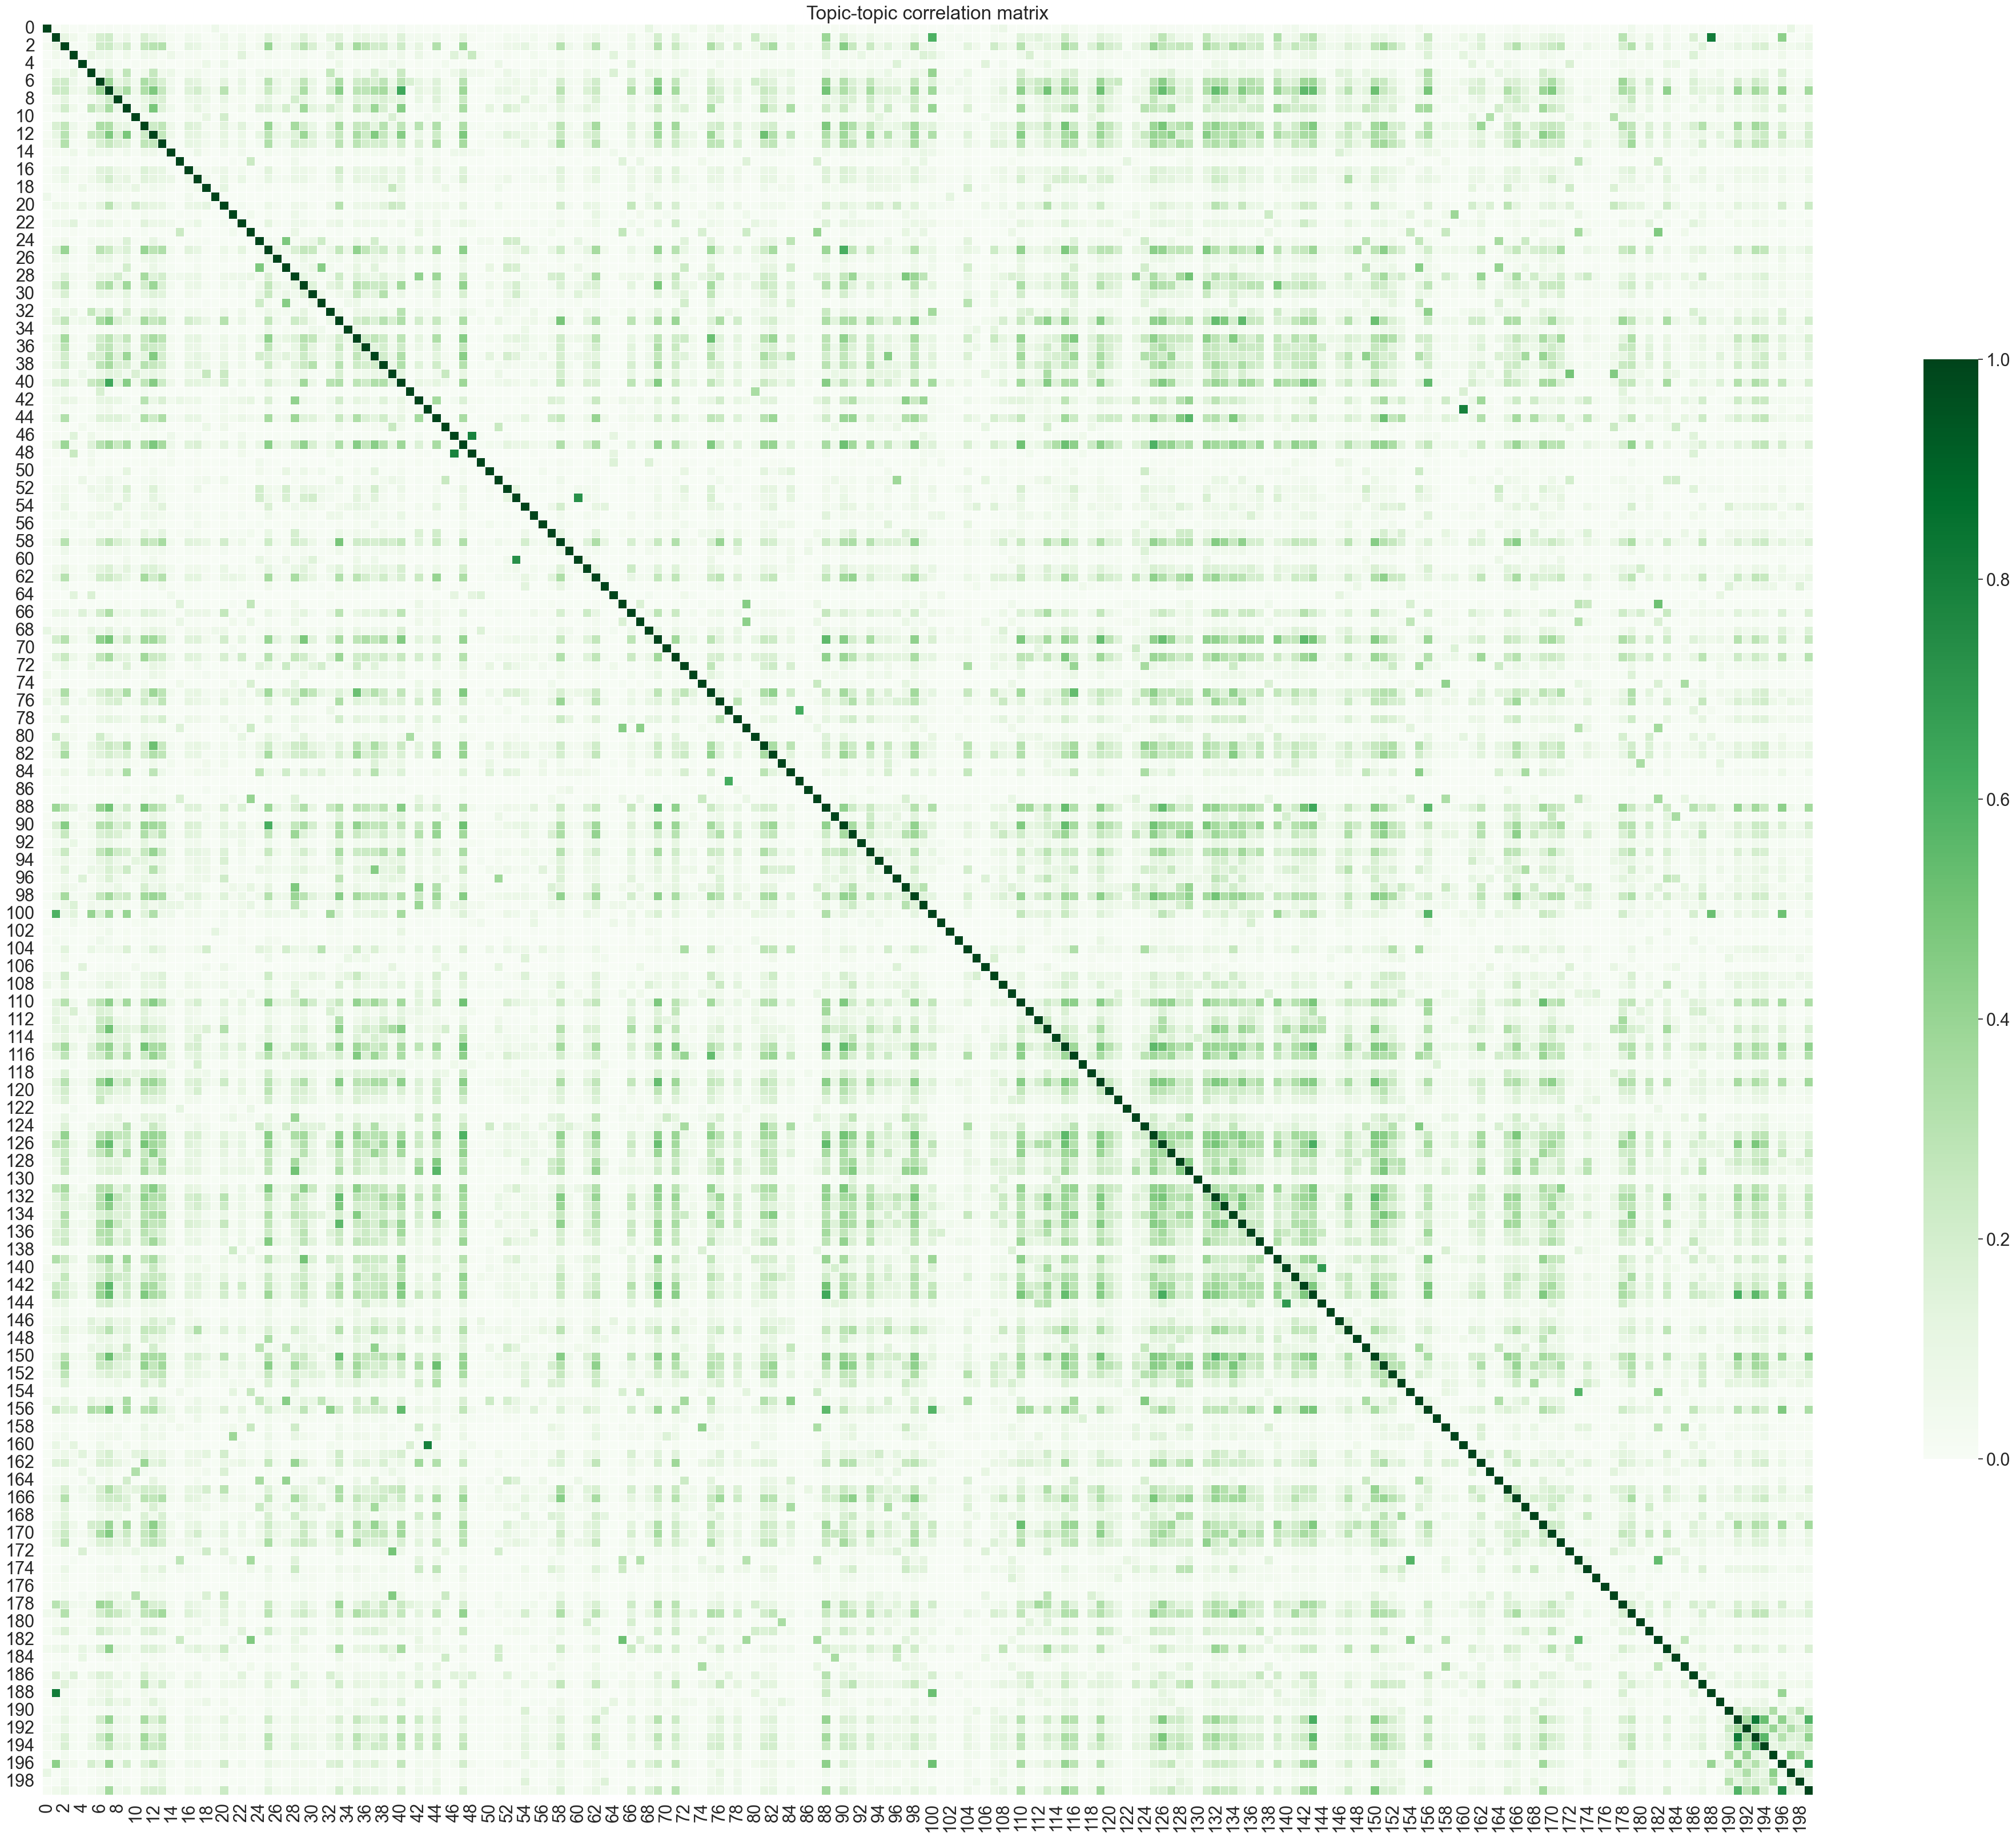

In [97]:
plot_corr_matrix(corr_matrix, save="Gazeta-ARTM_corr.eps")